In [1]:
%pip install -U scikit-learn
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from zlib import crc32

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from pandas.plotting import scatter_matrix

In [3]:
def get_housing_data():
    tarfile_path = Path("data/housing.tgz")
    if not tarfile_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarfile_path)
        with tarfile.open(tarfile_path) as housing_path:
            housing_path.extractall(path="data")
    return pd.read_csv(Path("data/housing/housing.csv"))

In [4]:
housing_data = get_housing_data()

In [5]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housing_data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

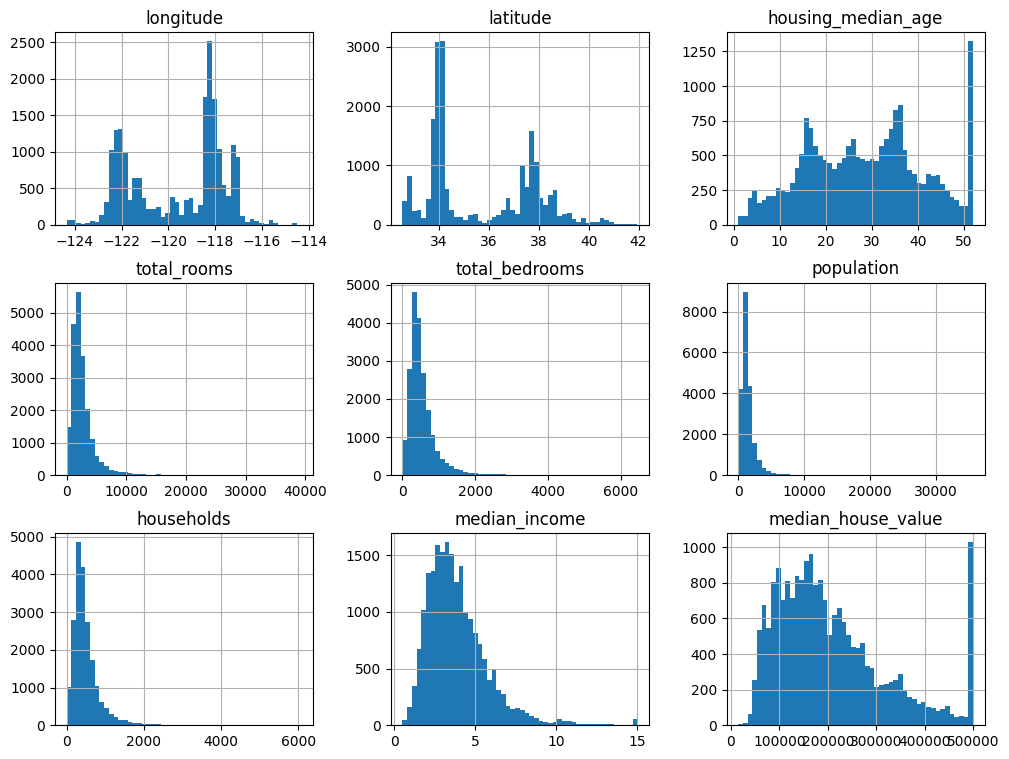

In [7]:
housing_data.hist(bins=50, figsize=(12,9))
plt.show()

In [8]:
def shuffle_split(data, split_ratio):
    np.random.seed(42)
    shuffled_ind = np.random.permutation(len(data))
    test_set_size = int(len(data) * split_ratio)
    test_ind = shuffled_ind[:test_set_size]
    train_ind = shuffled_ind[test_set_size:]
    return data.iloc[train_ind], data.iloc[test_ind]

In [9]:
train_set, test_set = shuffle_split(housing_data, 0.2)

In [10]:
def is_id_test(id, test_ratio):
    return crc32(np.int64(id)) < test_ratio * 2**32

def split_data_id(data, test_ratio, id):
    ids = data[id]
    in_test_set = ids.apply(lambda id_ : is_id_test(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_id = housing_data.reset_index()
train_set, test_set = split_data_id(housing_id, 0.2, "index")

In [12]:
train_set, test_set = train_test_split(housing_data, 
                                       test_size=0.2,
                                       random_state=42)

In [13]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"],
                                    bins=[0.,1.5,3.0,4.5,6.,np.inf],
                                    labels=[1,2,3,4,5])

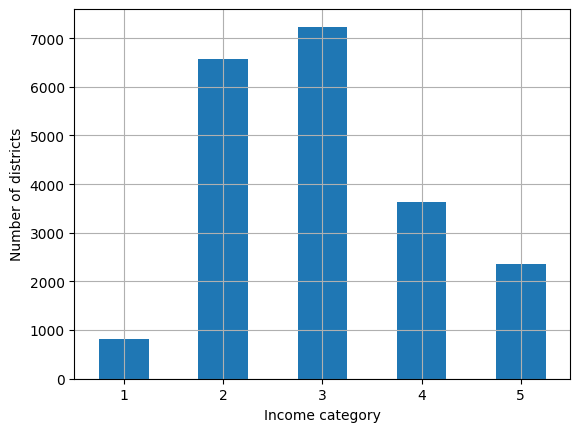

In [14]:
housing_data["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [15]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_ind, test_ind in splitter.split(housing_data, housing_data["income_cat"]):
    strat_train_set_n = housing_data.iloc[train_ind]
    strat_test_set_n = housing_data.iloc[test_ind]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [16]:
strat_train_set, strat_test_set = strat_splits[0]

In [17]:
strat_train_set, strat_test_set = train_test_split(
    housing_data,
    test_size=0.2,
    stratify=housing_data["income_cat"],
    random_state=42
)

In [18]:
for sets_ in (strat_train_set, strat_test_set):
    sets_.drop("income_cat", axis = 1, inplace = True)

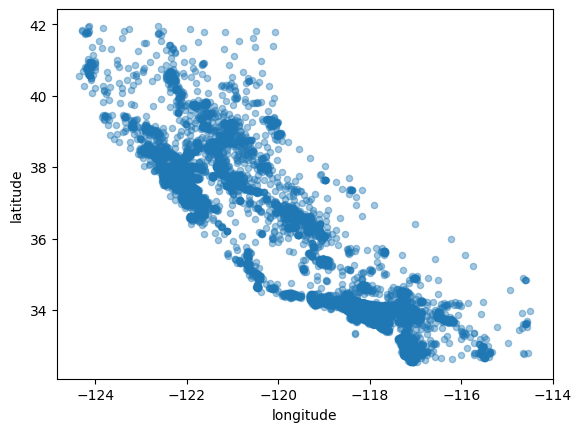

In [19]:
housing_data = strat_train_set.copy()

housing_data.plot(kind = "scatter",
                  x = "longitude",
                  y = "latitude",
                  grid = False,
                  alpha = 0.4)

plt.show()

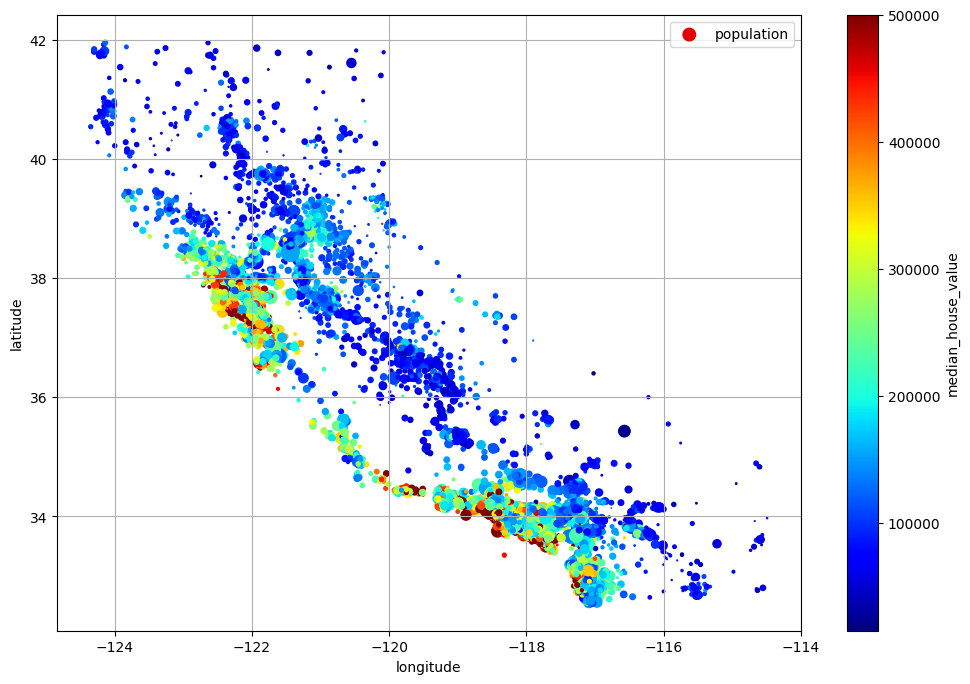

In [20]:
housing_data.plot(
    kind = "scatter",
    x = "longitude",
    y = "latitude",
    grid = True,
    s = housing_data["population"]/100,
    label = "population",
    c = "median_house_value",
    cmap = "jet",
    colorbar = True,
    legend = True,
    sharex = False,
    figsize = (12,8)
)

plt.show()

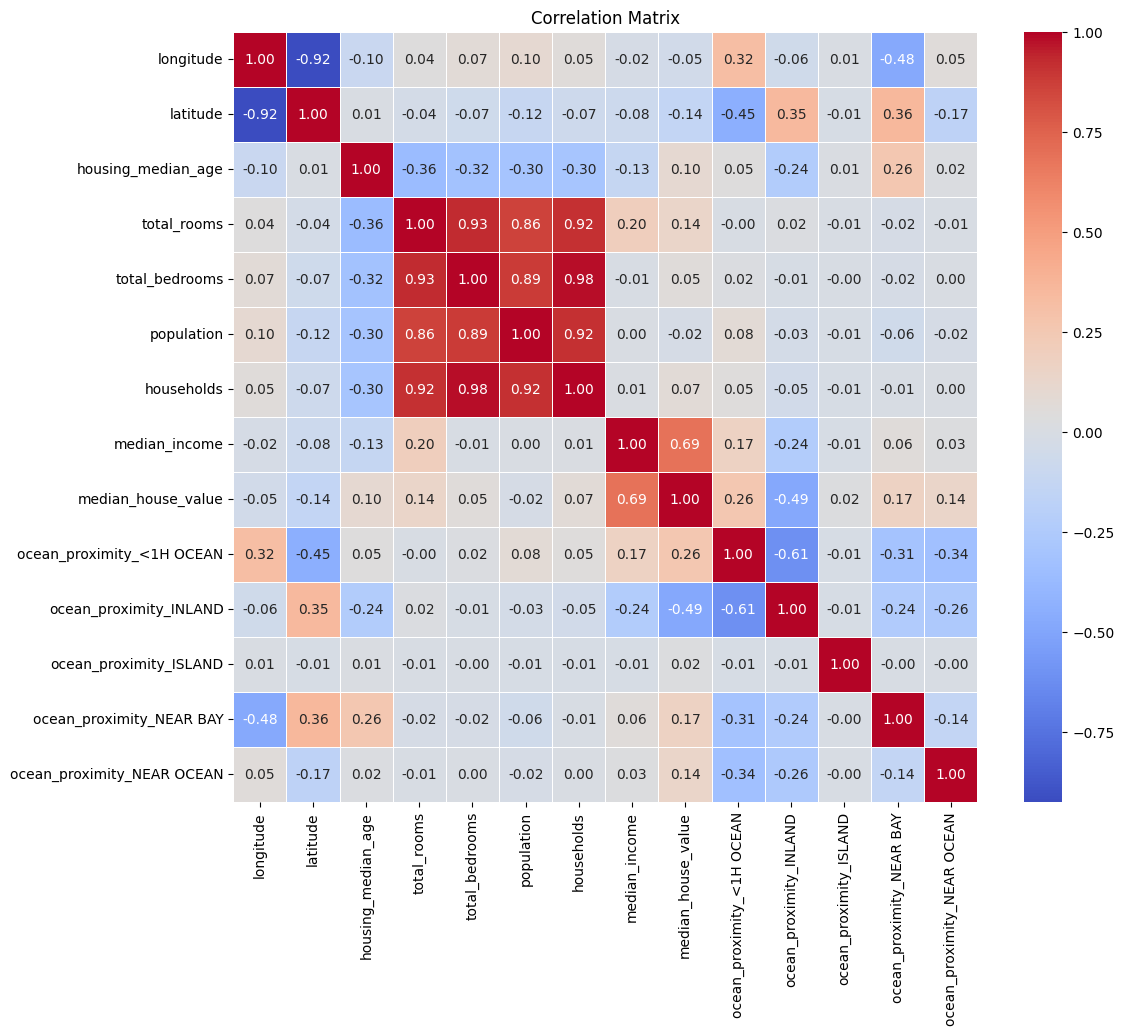

In [21]:
numeric_columns = housing_data.select_dtypes(include='number')

correlation_matrix_numeric = numeric_columns.corr()

categorical_columns = housing_data.select_dtypes(exclude='number')
encoded_categorical = pd.get_dummies(categorical_columns)

data_for_correlation = pd.concat([numeric_columns, encoded_categorical], axis=1)

correlation_matrix = data_for_correlation.corr()

# creating a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.688380
ocean_proximity_<1H OCEAN     0.257132
ocean_proximity_NEAR BAY      0.166398
ocean_proximity_NEAR OCEAN    0.138747
total_rooms                   0.137455
housing_median_age            0.102175
households                    0.071426
total_bedrooms                0.054635
ocean_proximity_ISLAND        0.023258
population                   -0.020153
longitude                    -0.050859
latitude                     -0.139584
ocean_proximity_INLAND       -0.485070
Name: median_house_value, dtype: float64

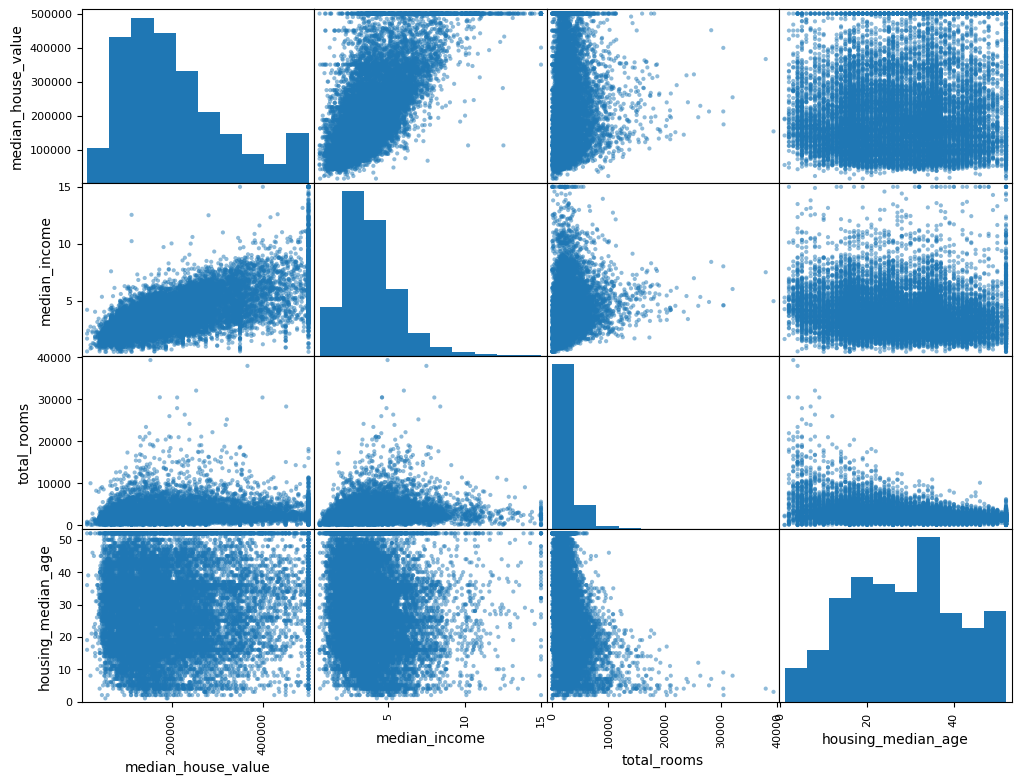

In [23]:
attr = ["median_house_value", 
        "median_income", 
        "total_rooms",
        "housing_median_age"]

scatter_matrix(housing_data[attr], figsize=(12, 9))
plt.show()

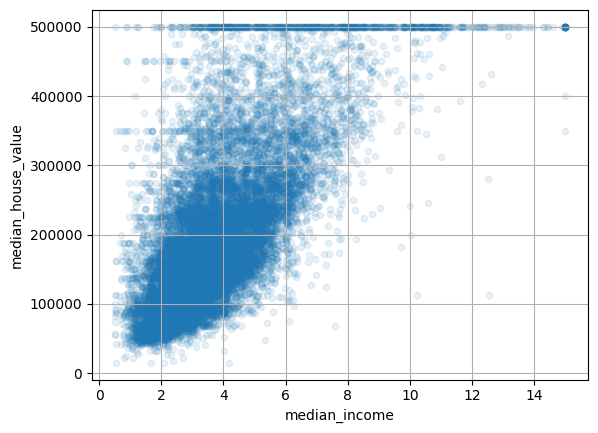

In [24]:
housing_data.plot(
    kind = "scatter",
    x = "median_income",
    y = "median_house_value",
    alpha = 0.1,
    grid = True
)

plt.show()

In [25]:
housing_data["rooms_per_house"] = housing_data["total_rooms"] / housing_data["households"]
housing_data["bedrooms_ratio"] = housing_data["total_bedrooms"] / housing_data["total_rooms"]
housing_data["people_per_house"] = housing_data["population"] / housing_data["households"]

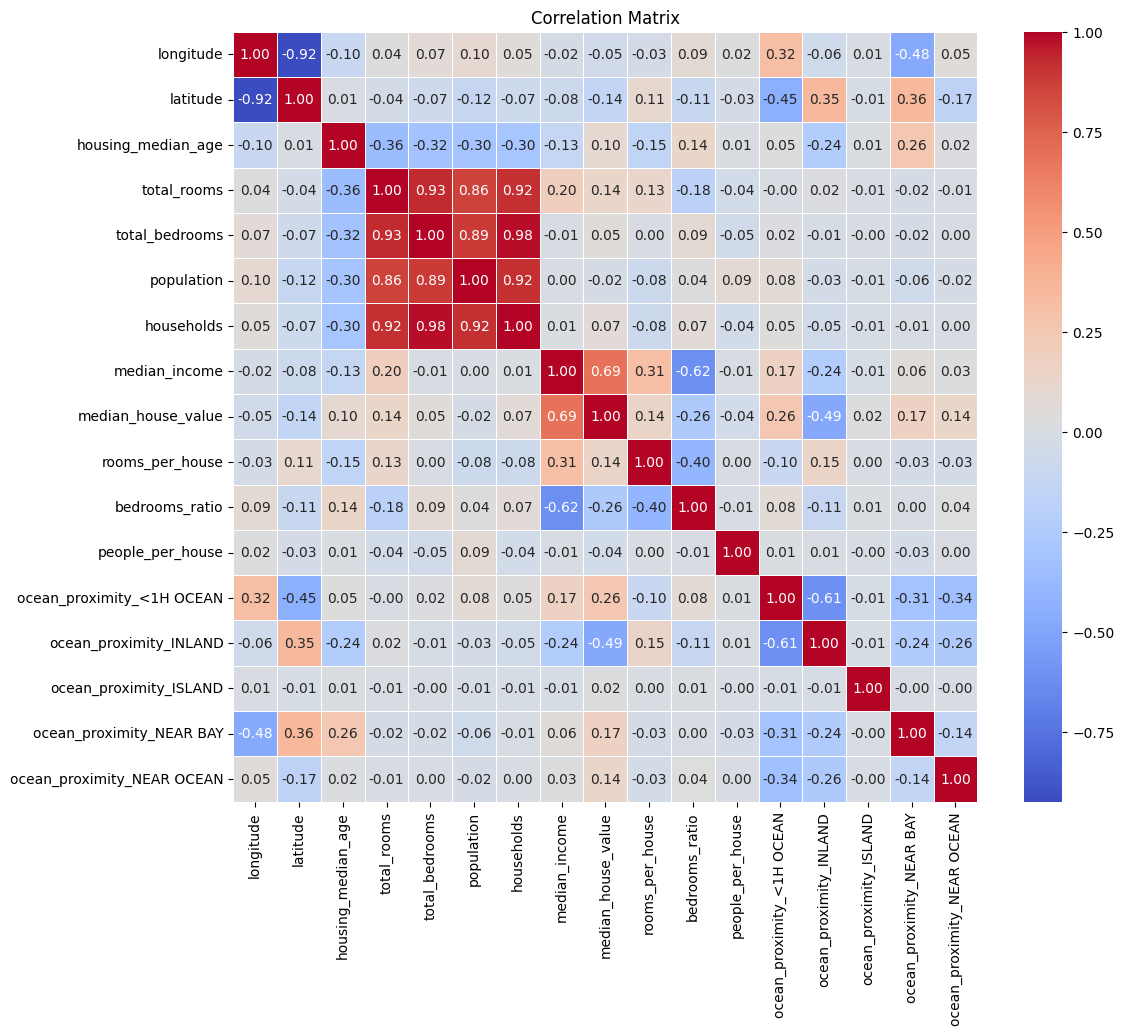

median_house_value            1.000000
median_income                 0.688380
ocean_proximity_<1H OCEAN     0.257132
ocean_proximity_NEAR BAY      0.166398
rooms_per_house               0.143663
ocean_proximity_NEAR OCEAN    0.138747
total_rooms                   0.137455
housing_median_age            0.102175
households                    0.071426
total_bedrooms                0.054635
ocean_proximity_ISLAND        0.023258
population                   -0.020153
people_per_house             -0.038224
longitude                    -0.050859
latitude                     -0.139584
bedrooms_ratio               -0.256397
ocean_proximity_INLAND       -0.485070
Name: median_house_value, dtype: float64

In [26]:
numeric_columns = housing_data.select_dtypes(include='number')

correlation_matrix_numeric = numeric_columns.corr()

categorical_columns = housing_data.select_dtypes(exclude='number')
encoded_categorical = pd.get_dummies(categorical_columns)

data_for_correlation = pd.concat([numeric_columns, encoded_categorical], axis=1)

correlation_matrix = data_for_correlation.corr()

# creating a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
correlation_matrix["median_house_value"].sort_values(ascending=False)

In [27]:
housing_data = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [28]:
imputer = SimpleImputer(strategy="median")

housing_num = housing_data.select_dtypes(include=[np.number])

imputer.fit(housing_num)


SimpleImputer(strategy='median')

In [29]:
X = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_cat= housing_data[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [31]:
# using one-hot encoding
cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [32]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [33]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [35]:
# category_encoders and representation learning
#df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
#                         columns=cat_encoder.get_feature_names_out(),
#                         index=df_test_unknown.index)
